In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import random

def ICA(datanum, X, datadim):
    
    X = np.array(X) 
    datasize, datanum = X.shape     # datasizeは時系列の数、datanumはデータ数
    
    # Xの各列ベクトルの平均を0にする
    X = X - np.mean(X, axis=0)
    X = X.T
    
    # 共分散行列を求める
    # 共分散行列VarSigmaは、以下の式で求める
    # VarSigma = E[x_j * x_j^T]
    VarSigma = np.zeros((datanum, datanum))
    for j in range(datasize):
        VarSigma += np.outer(X[:,j], X[:,j])    # np.outerは直積(ベクトルどうしのテンソル積)
    VarSigma /= datasize
    
    # 対称行列の直交行列による対角化
    def Eigenvalue_decomp(A):
        # A: 対称行列
        # return: 対角化された対称行列D, 直交行列E
        # A = EDE^T
        # D: 対角行列
        # E: 直交行列
        la, U = np.linalg.eig(A)
        D = np.diag(la)
        E, _ = np.linalg.qr(U)
        return D, E
    
    # 共分散行列を直交行列Eにより対角化する
    # D: 対角行列
    # E: 直交行列
    D, E = Eigenvalue_decomp(VarSigma)
    
    # V = E * D^(-1/2) * E^T    を求める
    D_sub = np.linalg.inv(np.power(D, 0.5))
    V = np.matmul(np.matmul(E, D_sub), E.T)

    # 列ベクトルがz_jになる行列Zを求める(このZを介してXを独立な信号源に変換する)
    Z = np.matmul(V, X)
    
    flag2 = 0
    while flag2 == 0:
        # 信号源は、観測データの線形結合で表されると仮定し、Zから独立な信号源への変換行列Wを求める
        # 適当な行列Wを用意し、初期化する
        # 行列のサイズは、datadim×datanumとする
        W = []
        for j in range(datadim):
            W.append([random.random() for i in range(datanum)])
        W = np.array(W)
        
        # Wを行ベクトル(datadim次元)ごとに正規化する
        for i in range(datadim):
            W[i] /= np.linalg.norm(W[i])
        print("W:",W)
            
        # Wの行ベクトルを更新する(第i行ベクトルを更新する)
        # Wの第i行ベクトルを転置したもの(N次元列ベクトル)をwt_iとし、以下の式で更新する
        # wt_i = E[z_j * (wt_i^T * z_j)^3] - 3 * wt_i
        # 更新したwt_iを正規化する
        # 変化している場合は、更新を続ける
        for i in range(datadim):
            wt_i = W[i]
            while True:
                wt_i_old = wt_i
                wt_i = np.zeros(datanum)
                for j in range(datasize):
                    wt_i += Z[:,j] * np.power(np.dot(wt_i_old, Z[:,j]), 3)
                wt_i /= datasize
                wt_i -= 3 * wt_i_old
                wt_i /= np.linalg.norm(wt_i)
                # 振動するのを防ぐために、wt_iの第1成分を正にする
                if wt_i[0] < 0:
                    wt_i *= -1
                # 更新幅が小さくなったら終了
                if np.linalg.norm(wt_i - wt_i_old) < 0.00001:
                    break
            # 初期値次第では、同じ行ベクトルが複数生成される場合があるので、それを防ぐ
            if i > 0:
                flag = 0
                # すでに生成された行ベクトルと同じものが生成された場合は、再生成する
                for j in range(i):
                    if np.linalg.norm(wt_i - W[j]) < 0.5:
                        W[i] = [random.random() for i in range(datanum)]
                        # 正規化する
                        W[i] /= np.linalg.norm(W[i])
                        i -= 1
                        flag = 1
                        break
                if flag == 0:
                    W[i] = wt_i
            else:
                W[i] = wt_i
        print("W:", W)
        
        # ZをWで変換し、独立な信号源Yを求める
        Y = np.matmul(W,Z)
        
        # Yの二つの行ベクトルの相関係数を求め、大きい場合は独立な信号源として扱わない
        flag2 = 1
        cormatrix = np.corrcoef(Y)
        for i in range(datadim):
            for j in range(i+1, datadim):
                # print("Y[",i,"]とY[",j,"]の相関係数:",np.corrcoef(Y[i], Y[j]))
                if cormatrix[i][j]>0.2:
                    flag2 = 0
                    break
            if flag2 == 0:
                break
    
    
    # 図示する
    plt.plot(Y[0])
    plt.plot(Y[1])
    plt.show()
    
    return Y

In [2]:
from PIL import Image

(512, 512)


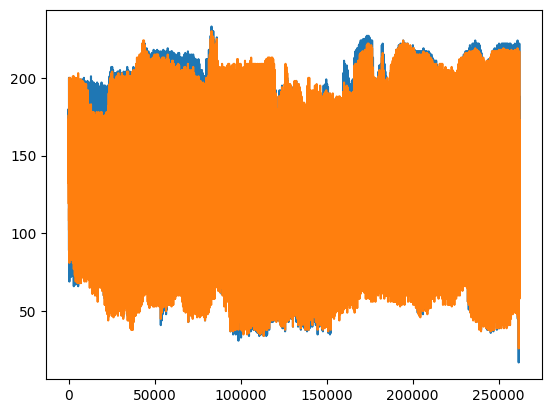

In [3]:
# 画像を読み込む
img1 = Image.open("data/image1.png")
img2 = Image.open("data/image2.png")
img_pixels1 = np.array(img1)
img_pixels2 = np.array(img2)
print(img_pixels1.shape)
horizontal, vertical= img_pixels1.shape

# 画像を一次元化する
img_pixels1d = img_pixels1.reshape(-1)
plt.plot(img_pixels1d)
img_pixels2d = img_pixels2.reshape(-1)
plt.plot(img_pixels2d)
original_data = np.array([img_pixels1d, img_pixels2d])
plt.show()

In [11]:
img1.show()

In [12]:
img2.show()

In [4]:
datanum = 2
# 各時系列データのデータ数が等しいことを確認する
for i in range(datanum):
    print("original_data[",i,"].shape:",original_data[i].shape)

data = np.array(original_data).T.tolist()

original_data[ 0 ].shape: (262144,)
original_data[ 1 ].shape: (262144,)


W: [[0.79647729 0.60466845]
 [0.1655718  0.98619774]]
W: [[ 0.99858365 -0.05320428]
 [ 0.03361538 -0.99943484]]


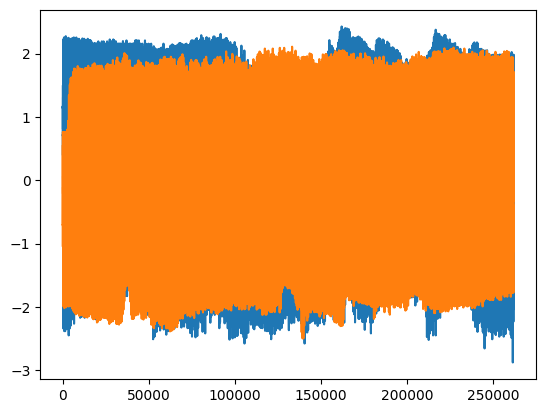

In [5]:
datadim = 2
Y = ICA(datanum, data, datadim)

In [6]:
# 画像を復元する
# unsined int型に変換する
Y *= 50
Y += 128    # あとから追加した
Y = Y.astype(np.uint8)
# 一次元化した画像を二次元化する
Image.fromarray(Y[0].reshape((horizontal, vertical))).save("data/image1_re.png")
Image.fromarray(Y[1].reshape((horizontal, vertical))).save("data/image2_re.png")

In [7]:
Image.open("data/image1_re.png").show()

In [8]:
Image.open("data/image2_re.png").show()